### Gerekli kütüphaneleri yükleme

In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np

### Veri setini yükleme

In [28]:
veri = pd.read_csv("MaksimumYolculukSayısı.csv")

### Eksik değerleri doldurma

In [29]:
veri = veri.fillna(0)

### Sayısal sütunlarda virgülleri kaldırma ve sayıları ondalık biçime dönüştürme

In [30]:
numeric_columns = veri.columns[1:-1]  
veri[numeric_columns] = veri[numeric_columns].replace({',': ''}, regex=True).astype(float)

### Bağımsız değişkenler ve hedef değişkeni seçme

In [31]:
X = veri.drop(columns=["Hat Adı", "2019", "İşletme Türü"])
y = veri["2019"]

### Eğitim ve test veri setlerine ayırma

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Model parametrelerini ayarlama

In [33]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

### XGBoost modelini oluşturma

In [34]:
model = xgb.XGBRegressor()

### GridSearchCV kullanarak en iyi parametreleri bulma

In [35]:
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='r2', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [50, 100, 150]},
             scoring='r2', verbose=1)

### En iyi parametreleri kullanarak modeli tekrar oluşturma

In [36]:
best_model = grid_search.best_estimator_

### Modeli eğitme

In [37]:
best_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### Eğitim ve test setleri üzerinde tahmin yapma

In [38]:
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

### Model performansını değerlendirme

In [39]:
print("Eğitim seti R2 skoru:", r2_score(y_train, y_train_pred))
print("Test seti R2 skoru:", r2_score(y_test, y_test_pred))

Eğitim seti R2 skoru: 0.9999855789298638
Test seti R2 skoru: 0.5258210944664669


### Gerçek 2019 verilerini alma

In [40]:
y_true = veri["2019"]

### Modelin tahmin ettiği 2019 verilerini alma

In [41]:
y_pred = best_model.predict(X)

### Modelin tahmin ettiği ve gerçek verileri karşılaştırma

In [42]:
comparison_df = pd.DataFrame({"Gerçek": y_true, "Tahmin": y_pred})
print(comparison_df)

      Gerçek         Tahmin
0   545062.0  646222.125000
1   629754.0  629527.250000
2    74720.0   74735.882812
3   353266.0  354562.968750
4    25184.0   25225.697266
5   648085.0  646222.125000
6     5723.0    5959.941895
7   249790.0  249644.281250
8    32861.0   32870.242188
9     4365.0    5959.941895
10    7428.0    7586.678223
11  246691.0    3121.313232
12    1873.0    3121.313232
13   26320.0   26354.544922
14  550871.0  548886.062500


### Modelin doğruluğunu yüzde olarak hesaplama ve yazdırma

In [43]:
accuracy = r2_score(y_true, y_pred)
accuracy_percent = accuracy * 100
print("Modelin doğruluğu: {:.2f}%".format(accuracy_percent))

Modelin doğruluğu: 92.28%


### Gerçek ve tahmin edilen yolcu sayısı görselleştirme

### Görselleştirme için verileri hazırlama

In [44]:
comparison_df["Hat Adı"] = veri["Hat Adı"]  
comparison_df = comparison_df.sort_values(by="Gerçek")

### Görselleştirme

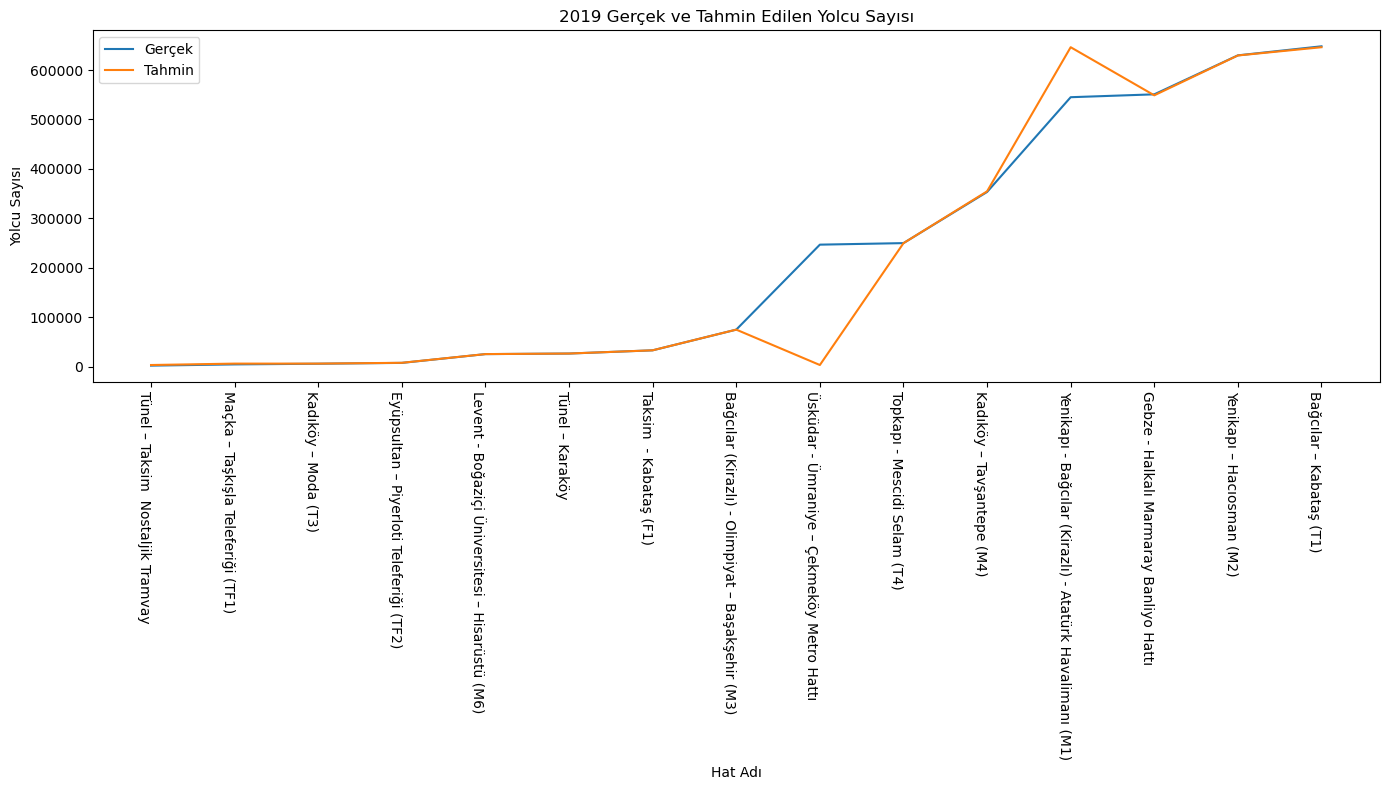

In [45]:
plt.figure(figsize=(14, 8))  
plt.plot(comparison_df["Hat Adı"], comparison_df["Gerçek"], label="Gerçek")
plt.plot(comparison_df["Hat Adı"], comparison_df["Tahmin"], label="Tahmin")
plt.xticks(rotation=270, ha='right')  
plt.xlabel("Hat Adı")
plt.ylabel("Yolcu Sayısı")
plt.title("2019 Gerçek ve Tahmin Edilen Yolcu Sayısı")
plt.legend()
plt.tight_layout()
plt.show()

### Hatların yolculuk yoğunlukları (2019) görselleştirme

### Her hat için 2019'daki toplam yolculuk sayılarını hesaplama

In [46]:
total_passengers_by_line = veri.groupby("Hat Adı")["2019"].sum()

### Grafik için verileri hazırlama

In [47]:
lines = total_passengers_by_line.index
passenger_counts = total_passengers_by_line.values

### Çubuk grafik oluşturma

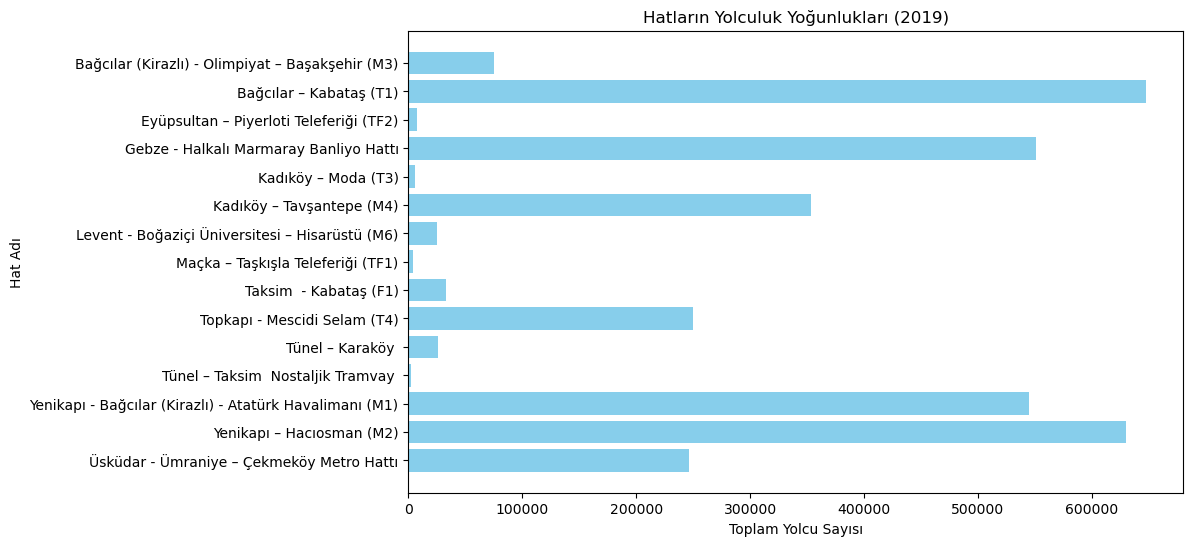

In [48]:
plt.figure(figsize=(10, 6))
plt.barh(lines, passenger_counts, color='skyblue')
plt.xlabel('Toplam Yolcu Sayısı')
plt.ylabel('Hat Adı')
plt.title('Hatların Yolculuk Yoğunlukları (2019)')
plt.gca().invert_yaxis()  
plt.show()

### Hatların ortalama yolculuk yoğunluğu (Tüm yıllar) görselleştirme

### Hatların yolculuk yoğunluklarını alma

In [49]:
hatlar = veri["Hat Adı"]

### Her bir hat için yıllara göre ortalama yolculuk yoğunluğunu hesaplama

In [50]:
ortalama_yolculuk_yogunlugu = veri.drop(columns=["Hat Adı", "İşletme Türü"]).mean()

### Görselleştirme

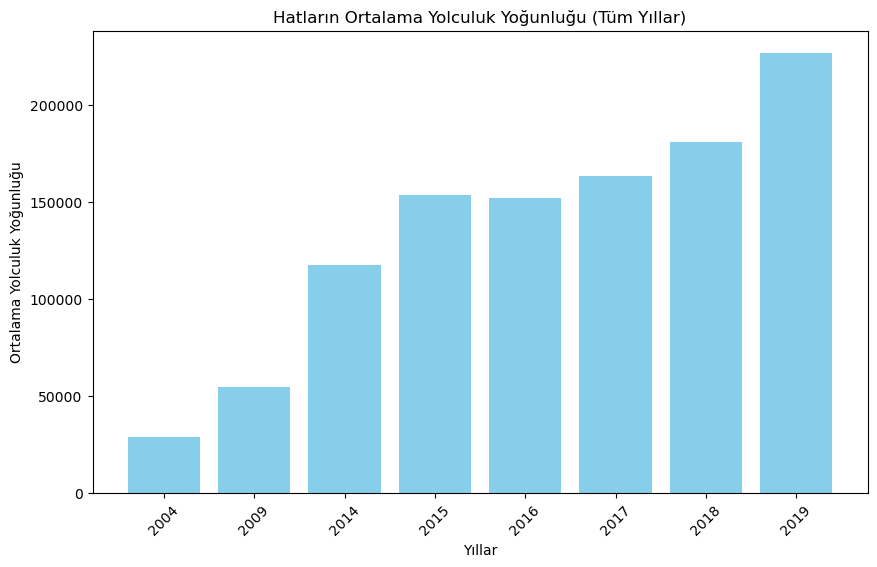

In [51]:
plt.figure(figsize=(10, 6))
plt.bar(ortalama_yolculuk_yogunlugu.index, ortalama_yolculuk_yogunlugu.values, color='skyblue')
plt.xlabel('Yıllar')
plt.ylabel('Ortalama Yolculuk Yoğunluğu')
plt.title('Hatların Ortalama Yolculuk Yoğunluğu (Tüm Yıllar)')
plt.xticks(rotation=45)
plt.show()

### Tüm hatların yolculuk yoğunluğu (Tüm yıllar) görselleştirme

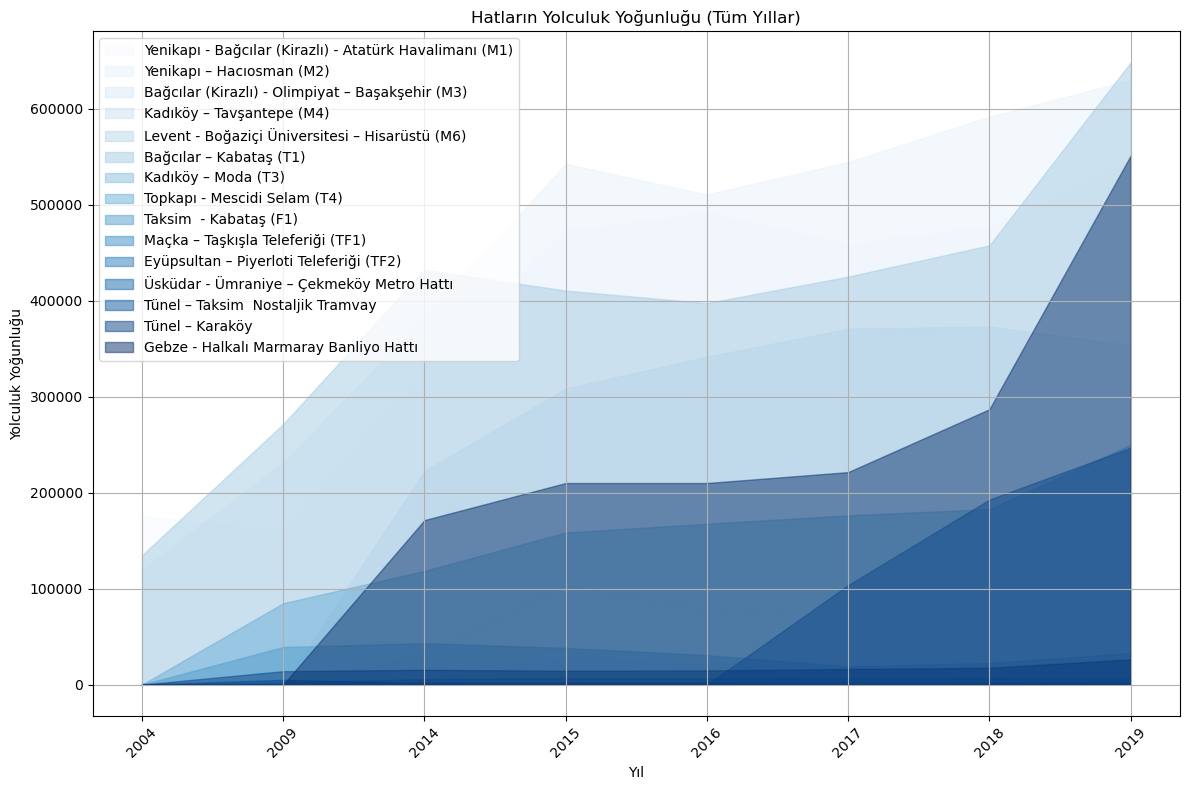

In [52]:
# Hatların yolculuk yoğunluklarını alma
hatlar = veri["Hat Adı"]
yillar = veri.columns[1:-1]

# Grafik boyutunu ayarlama
plt.figure(figsize=(12, 8))

# Renk paletini oluşturma
renkler = plt.cm.Blues(np.linspace(0, 1, len(hatlar)))

# Her hat için yolculuk yoğunluğunu alan grafiği çizme
for i, hat in enumerate(hatlar):
    yogunluklar = veri[veri["Hat Adı"] == hat][yillar].values.flatten()
    plt.fill_between(yillar, yogunluklar, label=hat, color=renkler[i], alpha=0.5)

# Eksen etiketlerini ve başlığı ekleme
plt.xlabel('Yıl')
plt.ylabel('Yolculuk Yoğunluğu')
plt.title('Hatların Yolculuk Yoğunluğu (Tüm Yıllar)')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.grid(True)

# Grafiği gösterme
plt.tight_layout()
plt.show()
